This notebook implements robot kinematics with the product of exponentials method in screw theory (see [Modern Robotics](http://hades.mech.northwestern.edu/index.php/Modern_Robotics)).

In [1]:
import numpy as np
import robosuite as suite

from PIL import Image
from IPython.display import display

In [2]:
from robosuite.utils.transform_utils import *
from transform import *

First we create an environment with off-screen rendering

In [3]:
env = suite.make(
    env_name="Lift",
    robots="Panda",
    has_renderer=False,
    ignore_done=True,
    use_camera_obs=True,
    camera_names="frontview",
)

Creating offscreen glfw


In [4]:
def getBodyMat(body_name):
    body_id = env.sim.model.body_name2id(body_name)
    R = np.array(env.sim.data.body_xmat[body_id]).reshape(3, 3)
    p = np.array(env.sim.data.body_xpos[body_id])
    M = pose2mat(R, p)
    return M

We reset the robot to its reset pose (all joint angles are set to zero)

In [5]:
jnt_idx = env.robots[0]._ref_joint_indexes
n = len(jnt_idx) # Franka is a 7-dof arm

for i in range(n):
    k = env.sim.model.jnt_bodyid[i]
    print(env.sim.model.body_id2name(k))

# reset the robot to its zero pose
env.reset()
env.robots[0].set_robot_joint_positions(np.zeros(n))

robot0_link1
robot0_link2
robot0_link3
robot0_link4
robot0_link5
robot0_link6
robot0_link7
Creating offscreen glfw


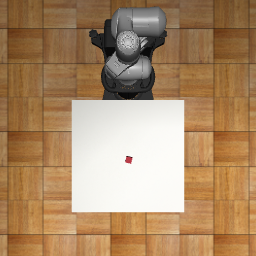

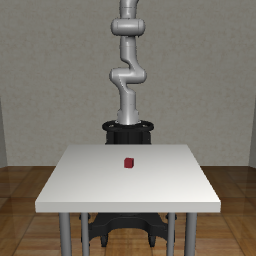

In [6]:
# set the arm to its zero position (all joint position = 0)
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

In [7]:
# the configuration of the end-effector frame relative to 
# the fixed base frame in its zero pose
w0 = np.array(env.sim.data.xaxis)[jnt_idx]
p0 = np.array(env.sim.data.xanchor)[jnt_idx]
v0 = -np.cross(w0, p0)

theta0 = env.sim.data.qpos[jnt_idx]

M0 = dict()
for i in range(1, 8):
    joint_name = "robot0_link{}".format(i)
    M0[joint_name] = getBodyMat(joint_name)

body_name = "robot0_right_hand"
M0[body_name] = getBodyMat(body_name)

# Joints are also bodies. These are two equivalent ways
# of retrieving the pose
body_idx = [env.sim.model.jnt_bodyid[x] for x in jnt_idx]
body_p0 = np.array(env.sim.data.body_xpos[body_idx])
assert np.allclose(body_p0, p0)

# sanity check (no motion no change)
# All Ts should be identity matrix
M = M0[body_name]
for i in reversed(range(n)):
    T = exp2mat(w0[i], v0[i], theta0[i])
    M = np.matmul(T, M)
assert np.allclose(M, M0["robot0_right_hand"])

Reset the arm to a natural pose. We will use it as the desired pose for the Inverse Kinematics part in the end.

Creating offscreen glfw


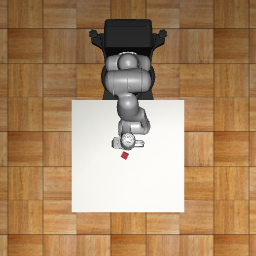

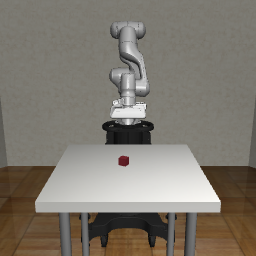

In [8]:
env.reset()
T_desired = getBodyMat(body_name)
theta_desired = env.sim.data.qpos[jnt_idx]

# visualize the new arm position
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

We move the robot by taking some random actions.

In [9]:
low, high = env.action_spec # get action limits
for i in range(100):
    action = np.random.uniform(low, high) # sample random action
    obs, reward, done, _ = env.step(action)

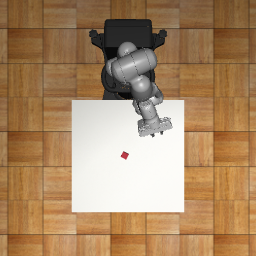

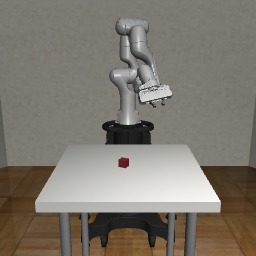

In [10]:
# visualize the new arm position
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

Now it's time to calculate *forward kinematics*. Using the *Product of Exponentials* formula, the forward kinematics computation is extremely simple and clean.

In [11]:
# Product of Exponentials formula
body_name = "robot0_right_hand"
theta = env.sim.data.qpos[jnt_idx]

def forward_kinematics(w_init, v_init, theta, M_init):
    M = M_init
    for i in reversed(range(n)):
        T = exp2mat(w_init[i], v_init[i], theta[i])
        M = np.matmul(T, M)
    return M    

M_final = forward_kinematics(w0, v0, theta, M0[body_name])

Now we check if our calculation of end-effector pose matches the ground-truth.

In [12]:
R, p = mat2pose(M_final)
R_gt, p_gt = mat2pose(getBodyMat(body_name))

# compute rotation error as angle of the two rotations
R_err = np.arccos((np.trace(np.matmul(R, R_gt.T)) - 1)/2.0)
p_err = np.linalg.norm(p - p_gt)

print("rotation err:", R_err)
print("position err:", p_err)

rotation err: 0.0007012165965878463
position err: 0.00020048368325615784


Moving on, we use the Product of Exponential form to calculate velocity kinematics.

In [13]:
def space_jacobian(w_init, v_init, theta):
    # screw axis at rest place
    S = np.hstack([w_init, v_init]) 
    J = []
    Ts = np.eye(4)

    # compute each column of the Jacobian
    for i in range(n):
        row = adjoint(Ts).dot(S[i])
        J.append(row)
        T = exp2mat(w0[i], v0[i], theta[i])
        Ts = np.matmul(Ts, T)

    return np.array(J).T

def velocity_kinematics(J, theta_dot):
    V = J.dot(theta_dot) # spatial twist
    return V

Js = space_jacobian(w0, v0, theta)
theta_dot = env.sim.data.qvel[jnt_idx]

V = velocity_kinematics(Js, theta_dot)

# rotational velocity of end-effector
w_pred = V[:3]

# linear velocity of end-effector
v = V[3:]
Vm = np.vstack([
    np.hstack([skew_sym(w_pred), v[:,np.newaxis]]),
    np.zeros([1, 4])
])

T_dot = np.matmul(Vm, M_final)
_, v_pred = mat2pose(T_dot)

Now let's check if our calculation of end-effector velocity matches ground-truth.

In [14]:
v_gt = env.sim.data.get_body_xvelp(body_name)
v_err = np.linalg.norm(v_pred - v_gt)
print('linear velocity err', v_err)

w_gt = env.sim.data.get_body_xvelr(body_name)
w_err = np.linalg.norm(w_pred - w_gt)
print('angular velocity err', w_err)

linear velocity err 5.142960733651052e-05
angular velocity err 5.953506586010766e-05


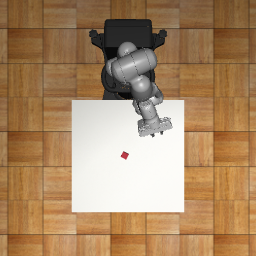

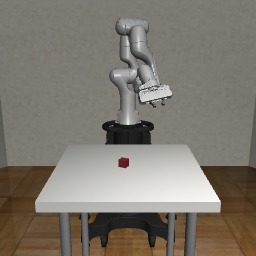

In [15]:
# set the arm to its zero position (all joint position = 0)
birdview = env.sim.render(height=256, width=256, camera_name="birdview")[::-1]
frontview = env.sim.render(height=256, width=256, camera_name="frontview")[::-1]
display(Image.fromarray(birdview), Image.fromarray(frontview))

Now let's check if our space Jacobian matches MuJoCo's internal Jacobians.

In [16]:
print(Js.T)

[[ 0.          0.          1.          0.          0.56        0.        ]
 [-0.21533818  0.97653954  0.         -1.21676826 -0.26831137 -0.54686214]
 [-0.03166167 -0.00698176  0.99947426  0.00869928  0.52025514  0.00390979]
 [ 0.36173386 -0.93226828  0.00494682  1.45864935  0.5683639   0.44973911]
 [ 0.19318719  0.0697664  -0.97867837 -0.16603583 -0.10347264 -0.04015099]
 [ 0.4755228  -0.87915013  0.03119491  1.06251944  0.5840148   0.26236548]
 [ 0.61485447  0.30678893 -0.72652222 -0.4725295   0.56892513 -0.15966056]]


In [17]:
# get ground-truth rotation jacobian
nv = env.sim.model.nv
env.sim.data.get_body_jacp(body_name).reshape(3, nv)[:, jnt_idx].dot(theta_dot)
print(env.sim.data.get_body_jacr(body_name).reshape(3, nv)[:, jnt_idx].T)

[[ 0.          0.          1.        ]
 [-0.2156776   0.97646463  0.        ]
 [-0.03162313 -0.00698479  0.99947546]
 [ 0.36173204 -0.93226907  0.00492998]
 [ 0.19348187  0.06989834 -0.97861074]
 [ 0.47582986 -0.87898043  0.03129455]
 [ 0.6151931   0.30718001 -0.72607017]]


In [18]:
# get ground-truth position jacobian
print(env.sim.data.get_body_jacp(body_name).reshape(3, nv)[:, jnt_idx].T)

[[-0.14856876  0.33724566  0.        ]
 [-0.05587634 -0.01234174 -0.36135141]
 [-0.14809114  0.33525919 -0.00234262]
 [ 0.34965541  0.13723492  0.29580355]
 [ 0.06224556 -0.1149836   0.00409379]
 [ 0.01280767  0.01181276  0.13704989]
 [ 0.          0.          0.        ]]


In [19]:
R, p = mat2pose(M_final)

In [20]:
print(np.matmul(R, Js[3:, :]).T)

[[ 0.15108739 -0.53058546 -0.09618561]
 [-1.31032297 -0.02355816 -0.36615972]
 [ 0.14921487 -0.49094228 -0.08641169]
 [ 1.51080747 -0.26866223  0.54611546]
 [-0.17564551  0.07070888 -0.06352556]
 [ 1.1062685  -0.37678832  0.41600127]
 [-0.29484298 -0.63074409 -0.29610969]]
